In [5]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

torch.set_printoptions(edgeitems=2, linewidth=75)

,datetime,stage,q,q_sigma
0,2021-05-26 09:35:18 [UTC-07:00],8.28,5534.902,110.133254
1,2021-04-19 09:48:23 [UTC-07:00],5.66,2268.957,43.989983
2,2021-03-01 11:48:01 [UTC-07:00],5.43,2048.322,37.622241
3,2020-11-16 09:29:49 [UTC-07:00],5.97,2562.925,52.304592
4,2020-10-01 08:04:39 [UTC-07:00],5.75,2411.594,45.524989
5,2020-08-24 08:27:30 [UTC-07:00],5.45,2062.588,38.936610
6,2020-07-15 07:34:16 [UTC-07:00],5.72,2244.671,40.083411
7,2020-06-03 07:28:36 [UTC-07:00],12.91,14199.957,449.182313
8,2020-05-28 08:38:09 [UTC-07:00],9.40,7538.191,126.918522
9,2020-04-21 08:38:05 [UTC-07:00],5.95,2580.047,47.388618


In [135]:
# import training data
import  pandas as pd
data = pd.read_csv('../data/co_channel.csv')
data = pd.read_csv('../data/green_channel.csv')

data.head()

,datetime,stage,q,q_sigma
0,2020-05-21 14:13:41 [UTC-07:00],7.04,12199.342,199.172931
1,2020-04-16 14:55:31 [UTC-07:00],4.43,4921.953,95.425619
2,2020-03-04 13:54:10 [UTC-07:00],2.99,2331.665,61.860500
3,2020-03-04 13:16:51 [UTC-07:00],2.94,2289.220,47.886745
4,2020-01-23 11:04:32 [UTC-07:00],2.96,2408.210,99.522964


In [136]:
#observations
t_s = torch.tensor(data['stage']).float().unsqueeze(1)
t_q = torch.tensor(data['q']).float().unsqueeze(1)

#uncertainties
t_q_sigma = torch.tensor(data['q_sigma']).float().unsqueeze(1)
t_s_sigma = torch.tensor([0.01]).float().unsqueeze(1)

t_q.shape

torch.Size([36, 1])

In [15]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

torch.Size([1, 1])

In [137]:
def training_loop_noval(n_epochs, optimizer, model, loss_fn, t_y_train,
                  t_x_train):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_x_train) # <1>
        loss_train = loss_fn(t_p_train, t_y_train)

        #t_p_val = model(t_u_val) # <1>
        #loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},")

In [88]:
class BasicNet(nn.Module): # start with the most physical
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.linear1 = nn.Linear(1, self.width) # can we modifty this to include the second bias term?
        self.activate1 = nn.ReLU()
        #self.activate1 = nn.Tanh()
        self.linear2 = nn.Linear(self.width, 1)
        #self.linear1_dropout = nn.Dropout(p=0.4)
        # page 221 dropout set to zero durion evaluation. pytorch switches between the modalities by calling model.train() model.eval()
        
        
    def forward(self, x):
        out = torch.log(x)
        out = self.linear1(out)
        out = self.activate1(out) #consider tan h
        out = self.linear2(out)
        #out = self.linear1_dropout(out)
        out = torch.exp(out)
        return out
        

In [165]:
#optimizer = optim.SGD(model.parameters(), lr=1e-4)
model = BasicNet(100)
optimizer = optim.Adam(model.parameters())
training_loop_noval(
    n_epochs = 10000,
    optimizer = optimizer,
    model = model,
    #loss_fn = nn.MSELoss(),
    loss_fn = MSLELoss,
    t_y_train = t_q,
    t_x_train = t_s)

Epoch 1, Training loss 66.9987,
Epoch 1000, Training loss 0.0023,
Epoch 2000, Training loss 0.0011,
Epoch 3000, Training loss 0.0010,
Epoch 4000, Training loss 0.0009,
Epoch 5000, Training loss 0.0008,
Epoch 6000, Training loss 0.0006,
Epoch 7000, Training loss 0.0005,
Epoch 8000, Training loss 0.0004,
Epoch 9000, Training loss 0.0003,
Epoch 10000, Training loss 0.0003,


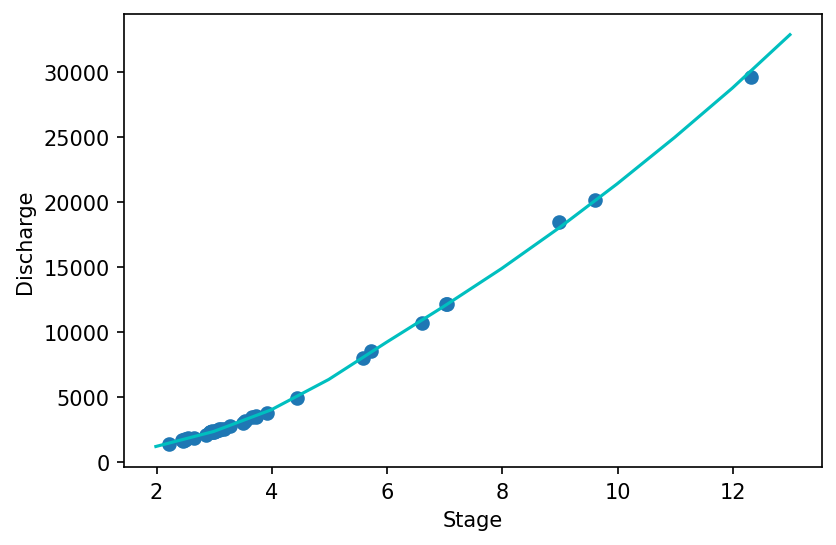

In [166]:
from matplotlib import pyplot as plt

s_range = torch.arange(t_s.min()*0.9, t_s.max()*1.1).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")
plt.plot(t_s.numpy(), t_q.numpy(), 'o')
plt.plot(s_range.numpy(), model(s_range).detach().numpy(), 'c-')
#plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

# v2 Basic version with dropuout

In [179]:
class BasicNet_v2(nn.Module): # start with the most physical
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.linear1 = nn.Linear(1, self.width) # can we modifty this to include the second bias term?
        self.dropout1 = nn.Dropout(p=0.2)
        self.activate1 = nn.ReLU()
        #self.activate1 = nn.Tanh()
        self.linear2 = nn.Linear(self.width, 1)
        
        # page 221 dropout set to zero durion evaluation. pytorch switches between the modalities by calling model.train() model.eval()
        
        
    def forward(self, x):
        out = torch.log(x)
        out = self.linear1(out)
        #out = self.linear1
        out = self.dropout1(out) #goes before activation for relu
        out = self.activate1(out) #consider tanh
        #out = nn.functional.dropout(out, p=0.2)
        out = self.linear2(out)
        out = torch.exp(out)
        return out
        

In [184]:
#optimizer = optim.SGD(model.parameters(), lr=1e-4)
model = BasicNet_v2(100)
optimizer = optim.Adam(model.parameters())
training_loop_noval(
    n_epochs = 10000,
    optimizer = optimizer,
    model = model,
    #loss_fn = nn.MSELoss(),
    loss_fn = MSLELoss,
    t_y_train = t_q,
    t_x_train = t_s)

Epoch 1, Training loss 78.9116,
Epoch 1000, Training loss 0.5481,
Epoch 2000, Training loss 0.3645,
Epoch 3000, Training loss 0.2870,
Epoch 4000, Training loss 0.2599,
Epoch 5000, Training loss 0.1965,
Epoch 6000, Training loss 0.2790,
Epoch 7000, Training loss 0.2726,
Epoch 8000, Training loss 0.3220,
Epoch 9000, Training loss 0.4168,
Epoch 10000, Training loss 0.1702,


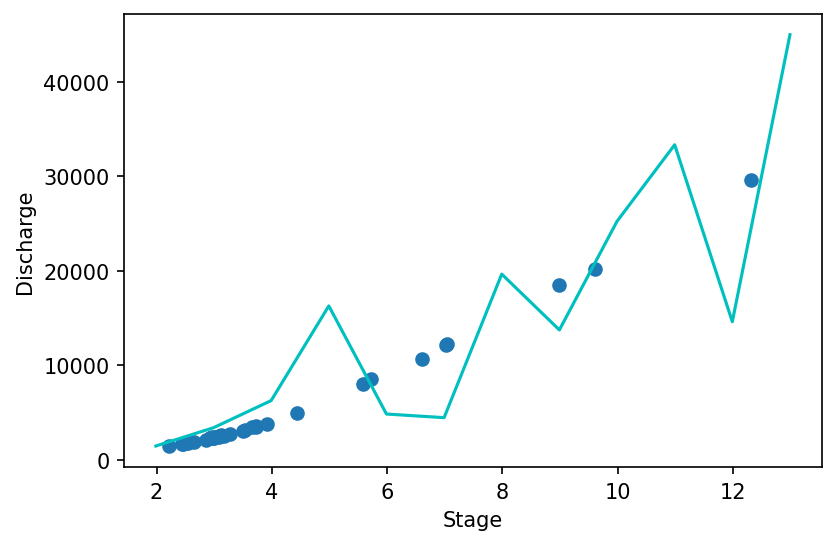

In [185]:
from matplotlib import pyplot as plt

s_range = torch.arange(t_s.min()*0.9, t_s.max()*1.1).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")
plt.plot(t_s.numpy(), t_q.numpy(), 'o')
plt.plot(s_range.numpy(), model(s_range).detach().numpy(), 'c-')
#plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [ ]:
# Scratch

In [ ]:
#additional layer no better than adding width
class BasicNet2(nn.Module): # start with the most physical
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.linear1 = nn.Linear(1, self.width) # can we modifty this to include the second bias term?
        self.activate1 = nn.ReLU()
        #self.activate1 = nn.Tanh()
        self.linear2 = nn.Linear(self.width, 8)
        self.activate2 = nn.ReLU()
        self.linear3 = nn.Linear(8, 1)
        #self.linear1_dropout = nn.Dropout(p=0.4)
        # page 221 dropout set to zero durion evaluation. pytorch switches between the modalities by calling model.train() model.eval()
        
        
    def forward(self, x):
        out = torch.log(x)
        out = self.linear1(out)
        out = self.activate1(out) #consider tan h
        out = self.linear2(out)
        out = self.activate2(out)
        out = self.linear3(out)
        #out = self.linear1_dropout(out)
        out = torch.exp(out)
        return out
        

In [157]:
#optimizer = optim.SGD(model.parameters(), lr=1e-4)
model = BasicNet2(100)
optimizer = optim.Adam(model.parameters())
training_loop_noval(
    n_epochs = 10000,
    optimizer = optimizer,
    model = model,
    #loss_fn = nn.MSELoss(),
    loss_fn = MSLELoss,
    t_y_train = t_q,
    t_x_train = t_s)

Epoch 1, Training loss 70.3008,
Epoch 1000, Training loss 0.0017,
Epoch 2000, Training loss 0.0012,
Epoch 3000, Training loss 0.0010,
Epoch 4000, Training loss 0.0009,
Epoch 5000, Training loss 0.0009,
Epoch 6000, Training loss 0.0008,
Epoch 7000, Training loss 0.0008,
Epoch 8000, Training loss 0.0006,
Epoch 9000, Training loss 0.0004,
Epoch 10000, Training loss 0.0004,


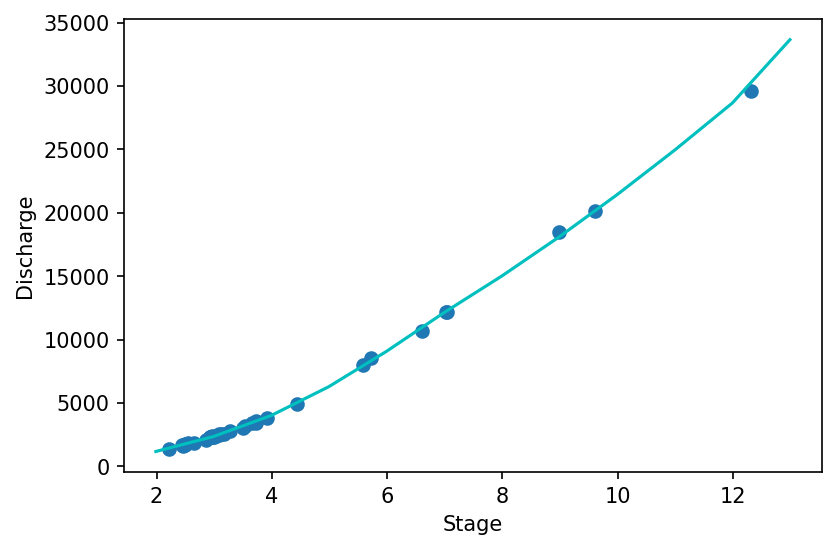

In [160]:
from matplotlib import pyplot as plt

s_range = torch.arange(t_s.min()*0.9, t_s.max()*1.1).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")
plt.plot(t_s.numpy(), t_q.numpy(), 'o')
plt.plot(s_range.numpy(), model(s_range).detach().numpy(), 'c-')
#plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


In [133]:
#optimizer = optim.SGD(model.parameters(), lr=1e-4)
model = BasicNet(50)
optimizer = optim.Adam(model.parameters())
training_loop_noval(
    n_epochs = 10000,
    optimizer = optimizer,
    model = model,
    loss_fn = nn.MSELoss(),
    #loss_fn = MSLELoss,
    t_y_train = t_q,
    t_x_train = t_s)

Epoch 1, Training loss 217932000.0000,
Epoch 1000, Training loss 4690050.0000,
Epoch 2000, Training loss 144482.3594,
Epoch 3000, Training loss 144311.7969,
Epoch 4000, Training loss 144309.7344,
Epoch 5000, Training loss 144311.2500,
Epoch 6000, Training loss 144541.4219,
Epoch 7000, Training loss 148335.0938,
Epoch 8000, Training loss 152353.3125,
Epoch 9000, Training loss 144313.2031,
Epoch 10000, Training loss 144334.6406,


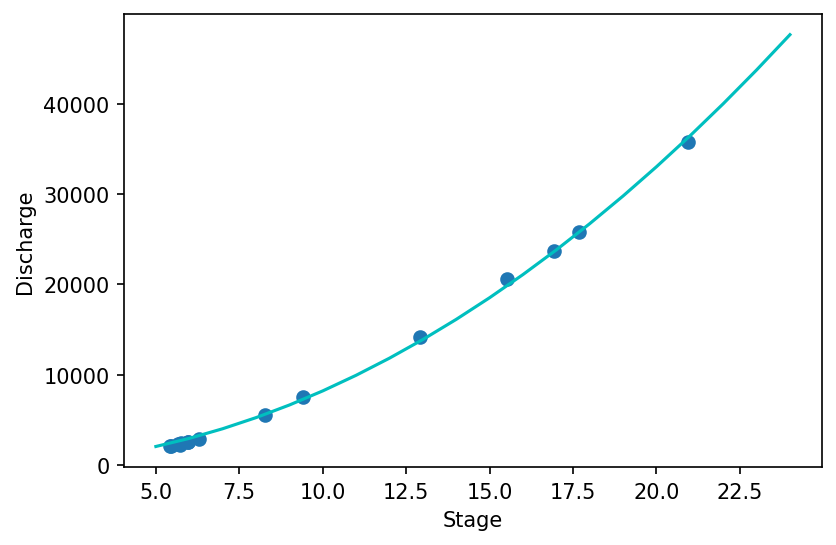

In [134]:
from matplotlib import pyplot as plt

s_range = torch.arange(5., 25.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")
plt.plot(t_s.numpy(), t_q.numpy(), 'o')
plt.plot(s_range.numpy(), model(s_range).detach().numpy(), 'c-')
#plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


In [ ]:
#optimizer = optim.SGD(model.parameters(), lr=1e-4)
model = BasicNet(50)
optimizer = optim.Adam(model.parameters())
training_loop_noval(
    n_epochs = 10000,
    optimizer = optimizer,
    model = model,
    loss_fn = nn.MSELoss(),
    #loss_fn = MSLELoss,
    t_y_train = t_q,
    t_x_train = t_s)

In [ ]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

In [109]:

class BasicNet(nn.Module): # start with the most physical
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.linear1 = nn.Linear(1, self.width) # can we modifty this to include the second bias term?
        self.activate1 = nn.ReLU()
        #self.activate1 = nn.Tanh()
        self.linear2 = nn.Linear(self.width, 1)
        #self.linear1_dropout = nn.Dropout(p=0.4)
        # page 221 dropout set to zero durion evaluation. pytorch switches between the modalities by calling model.train() model.eval()
        
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.activate1(out) #consider tan h
        out = self.linear2(out)
        #out = self.linear1_dropout(out)
        return out
        

In [111]:
#optimizer = optim.SGD(model.parameters(), lr=1e-4)
model = BasicNet(20)
optimizer = optim.Adam(model.parameters())
training_loop_noval(
    n_epochs = 5000,
    optimizer = optimizer,
    model = model,
    loss_fn = nn.MSELoss(),
    t_y_train = t_u,
    t_x_train = t_c)

Epoch 1, Training loss 2834.3909,
Epoch 1000, Training loss 171.4002,
Epoch 2000, Training loss 12.8150,
Epoch 3000, Training loss 7.5660,
Epoch 4000, Training loss 7.5651,
Epoch 5000, Training loss 7.5650,


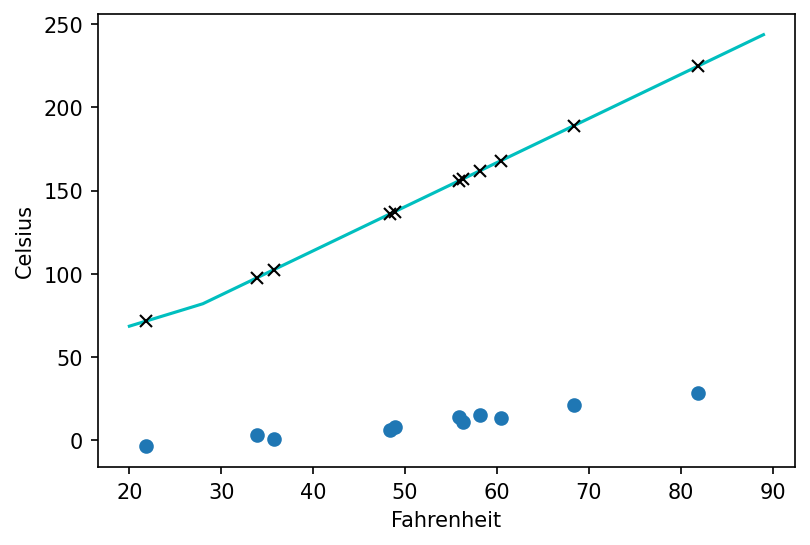

In [113]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), model(1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), model(1 * t_u).detach().numpy(), 'kx')

In [ ]:
from matplotlib import pyplot as plt

s_range = torch.arange(5., 25.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")
plt.plot(t_c.numpy(), t_u.numpy(), 'o')
plt.plot(s_range.numpy(), model(s_range).detach().numpy(), 'c-')
#plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


In [116]:
def MSLELoss(y, x):
    squared_diffs = torch.log(y/x)**2
    return squared_diffs.mean()

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [ ]:
# define model
# physical version with n_segments and sigma terms

#generic version
class NetRatingDropout(nn.Module): # start with the most physical
    def __init__(self, width):
        super().__init__()
        self.n_segments = width
        self.linear1 = nn.Linear(1, width) # can we modifty this to include the second bias term?
        #self.linear1_dropout = nn.Dropout(p=0.4)
        # page 221 dropout set to zero durion evaluation. pytorch switches between the modalities by calling model.train() model.eval()
        
        
    def forward(self, x):
        out = tt.log(x)
        out = self.linear(out)
        out = nn.ReLU() #consider tan h
        #out = self.linear1_dropout(out)
        out = nn.functional.dropout(out, p=0.4)
        out = tt.exp(out)
        return out
        

# define a much more generic version
        
# measurement uncertainty model

# add random noise to training set during each epoch.

In [ ]:
# Training

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    

In [ ]:
# Plot results

In [ ]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


In [ ]:
# define NN where each neuron is treated like a segment , then use relU will efectively turn off segments when stage drops below critical threshold, we also want to max the flow
# either as part of the layer but probably better as part of the activation function. If the latter we need a way to pass parameters from the layer to the activation function.

# https://auro-227.medium.com/writing-a-custom-layer-in-pytorch-14ab6ac94b77
class MyLinearLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        # initialize weights and biases
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init

    def forward(self, x):
        w_times_x= torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  # w times x + b






#https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear

class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
          additional dimensions and :math:`H_{in} = \text{in\_features}`
        - Output: :math:`(N, *, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )



In [ ]:
pytorch style guides
https://github.com/vahidk/EffectivePyTorch
https://github.com/IgorSusmelj/pytorch-styleguide